# Classification Project
The following classifier guesses whether a movie is romance or action, using only the numbers of times words appear in the movies's screenplay.

In [1]:
# Importing some basic libraries

import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg', warn=False)
%matplotlib inline
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## The Dataset

In this project, the dataset will be movie screenplays. A list of 5,000 words were previously compiled that may or may not occur in the dialog of a movie. For each movie, the `movies.csv` file tells us the frequency with which each of these words occurs in its screenplay. All words have been converted to lowercase.

In [2]:
movies = pd.read_csv('movies.csv')
movies.iloc[[125], [0,1,2,3,4,5,10,30,5005]]

,Title,Genre,Year,Rating,# Votes,# Words,it,not,fling
125,the matrix,action,1999,8.7,389480,3792,0.030327,0.008703,0.0


The above cell prints a few columns of the row for the action movie *The Matrix*.  The movie contains 3792 words. The word "it" appears ${0.030327}\times{3792} \approx 115$ times. The word "not" appears ${0.008703}\times{3792} \approx 33$ times. The word "fling" doesn't appear at all.

All movie titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [3]:
def row_for_title(title):
    return movies[movies['Title'] == title]

This dataset was extracted from [a Kaggle dataset from Cornell University](https://www.kaggle.com/Cornell-University/movie-dialog-corpus). After transforming the dataset (e.g., converting the words to lowercase, removing profanity, and converting the counts to frequencies), this dataset contains the frequency of 5000 common words in each movie.

In [4]:
print('Words with frequencies:', movies.iloc[:,6:].shape[1]) 
print('Movies with genres:', movies.shape[0])

Words with frequencies: 5000
Movies with genres: 242


The `movies` dataset will be used to *train* the movie genre classifiers and to *test* the performance of the classifiers. The dataset has already been permuted randomly, so it'll be split such that the top will be used for training and the rest for test. 

In [5]:
# The proportion of data that we want to designate for training
training_proportion = 17/20

num_movies = movies.shape[0]
num_train = int(num_movies * training_proportion)
num_valid = num_movies - num_train

train_movies = movies.iloc[:num_train,:]
test_movies = movies.iloc[num_train:num_movies,:]

print("Training: ",   train_movies.shape[0], ";",
      "Test: ",       test_movies.shape[0])

Training:  205 ; Test:  37


The following horizontal bar chart shows the proportion of Romance movies in each dataset.

<BarContainer object of 2 artists>

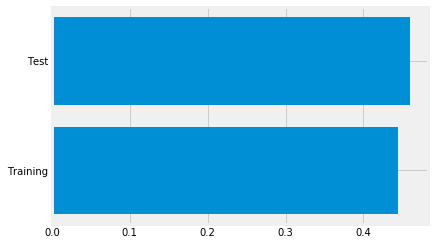

In [6]:
def romance_proportion(table):
    """Return the proportion of movies in a table that have the Romance genre."""
    romance = (table[table['Genre']=='romance'].shape[0])/(table.shape[0])
    return romance

props = pd.DataFrame({'Dataset': ['Training', 'Test'],
                     'Proportion of Romance Movies': [romance_proportion(train_movies),romance_proportion(test_movies)]})

plt.barh(props['Dataset'], props['Proportion of Romance Movies'])

## K-Nearest Neighbors

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some *features* of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples. A feature we have about each movie is *the proportion of times a particular word appears in the movies*, and the labels are two movie genres: romance and action.

### Classifying a movie

In k-NN, we classify a movie by finding the `k` movies in the *training set* that are most similar according to the features chosen. Those movies with similar features are called the *nearest neighbors*.  The k-NN algorithm assigns the movie to the most common category among its `k` nearest neighbors.

For similarity calculations, the *distance* between two movies will be the Euclidean distance $\sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$ between them.

For example, in the movie *Titanic* (in the training set), 0.0009768 of all the words in the movie are "money" and 0.0017094 are "feel".  Its distance from *Batman Returns* on this 2-word feature set is $\sqrt{(0.000502 - 0.0009768)^2 + (0.004016 - 0.0017094)^2} \approx 0.00235496$.

A third movie, *The Avengers* (in the training set), is 0 "money" and 0.001115 "feel".

The function below creates a plot to display the "money" and "feel" features of a test movie and some training movies. As you can see in the result, *Batman Returns* is more similar to *Titanic* than to *The Avengers* based on these features.

[-0.001, 0.0015, -0.001, 0.006]

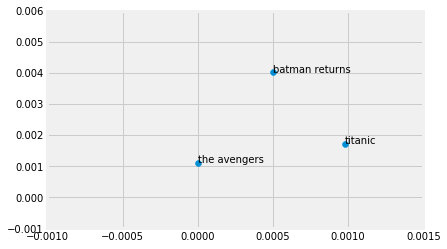

In [8]:
def plot_with_two_features(test_movie, training_movies, x_feature, y_feature):
    """Plot a test movie and training movies using two features."""
    test_row = row_for_title(test_movie)
    distances = pd.DataFrame({x_feature: [test_row.iloc[0][x_feature]],
                            y_feature: [test_row.iloc[0][y_feature]],
                            'Genre': ['unknown'],
                            'Title': [test_movie]})
    for i in range(len(training)):
        row = row_for_title(training[i])
        distances.loc[i+1] = [row.iloc[0]['money'], row.iloc[0]['feel'], row.iloc[0]['Genre'], training[i]]
        
    fig, ax = plt.subplots()
    ax.scatter(distances[x_feature], distances[y_feature])
    for i, txt in enumerate(distances['Title']):
        ax.annotate(txt, (distances[x_feature][i], distances[y_feature][i]))


training = ["titanic", "the avengers"] 
plot_with_two_features("batman returns", training, "money", "feel")
plt.axis([-0.001, 0.0015, -0.001, 0.006])

In [9]:
# Computing the distance between the two action movies, Batman Returns and *The Avengers*
# using the `money` and `feel` features only 

batman = row_for_title("batman returns") 
avengers = row_for_title("the avengers")

x_a = avengers.iloc[0]['money']
x_b = batman.iloc[0]['money']
y_a = avengers.iloc[0]['feel']
y_b = batman.iloc[0]['feel']

romance_distance = np.sqrt(((x_a - x_b)**2) + ((y_a - y_b)**2))
romance_distance

0.0029437356216700243

Adding a third training movie, *The Terminator*, the point closest to *Batman Returns* is now *The Terminator* instead of a romance movie, *Titanic*.

[-0.001, 0.0015, -0.001, 0.006]

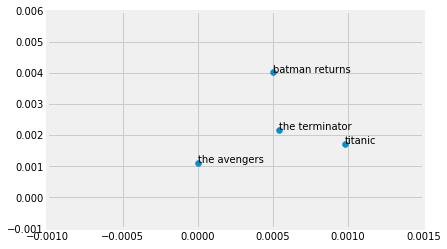

In [11]:
training = ["the avengers", "titanic", "the terminator"] 
plot_with_two_features("batman returns", training, "money", "feel") 
plt.axis([-0.001, 0.0015, -0.001, 0.006])

The function `distance_two_features` computes the Euclidean distance between any two movies, using two features.

In [12]:
def distance_two_features(title0, title1, x_feature, y_feature):
    """Compute the distance between two movies with titles title0 and title1
    
    Only the features named x_feature and y_feature are used when computing the distance.
    """
    title0x = row_for_title(title0).iloc[0][x_feature]
    title1x = row_for_title(title1).iloc[0][x_feature]
    title0y = row_for_title(title0).iloc[0][y_feature]
    title1y = row_for_title(title1).iloc[0][y_feature]
    distance = np.sqrt(((title0x - title1x)**2) + ((title0y - title1y)**2))
    return distance

# Shows that Batman Returns is closer to The Terminator than The Avengers
for movie in ["the terminator", "the avengers"]:
    movie_distance = distance_two_features(movie, "batman returns", "money", "feel")
    print(movie, 'distance:\t', movie_distance)

the terminator distance:	 0.0018531387547749904
the avengers distance:	 0.0029437356216700243


In [13]:
def distance_from_batman_returns(title):
    """The distance between the given movie and "batman returns", based on the features "money" and "feel".
    
    This function takes a single argument:
      title: A string, the name of a movie.
    """
    return distance_two_features(title, 'batman returns', 'money', 'feel')

Using the features `"money"` and `"feel"`, these are the names and genres of the 7 movies in the **training set** closest to "batman returns".

In [14]:
train_movies['distance'] = train_movies['Title'].apply(lambda x: distance_from_batman_returns(x))
sorted_movies = train_movies.loc[:,['Title', 'Genre', 'money', 'feel', 'distance']].sort_values(by=['distance'], inplace = False).reset_index(drop=True)
close_movies = sorted_movies.iloc[:7,:]
close_movies

C:\Users\gxb9tug\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Title,Genre,money,feel,distance
0,the bridges of madison county,romance,0.000565,0.004333,0.000323
1,the fisher king,romance,0.000618,0.003504,0.000525
2,broadcast news,romance,0.000137,0.003553,0.000590
3,hellboy,action,0.000000,0.003350,0.000834
4,as good as it gets,romance,0.000523,0.003139,0.000878
5,spider-man,action,0.000347,0.003126,0.000903
6,harold and maude,romance,0.000000,0.003023,0.001112


In [15]:
def most_common(label, table):
    """The most common element in a column of a table.
    
    This function takes two arguments:
      label: The label of a column, a string.
      table: A table.
     
    It returns the most common value in that column of that table.
    """
    common = table.groupby(label).size().rename('Count').reset_index().sort_values(['Count'], ascending = False)
    return common[label].iloc[0]

# Calling most_common on the table of 7 nearest neighbors classifies
# "batman returns" as a romance movie, 5 votes to 2. 
most_common('Genre', close_movies)

'romance'

## Features

The function computes the Euclidean distance between two **arrays** of features of *arbitrary* (but equal) length. It computes the distance between the first movie in the training set and the first movie in the test set, *using all of the features*.

In [16]:
def distance(features1, features2):
    """The Euclidean distance between two arrays of feature values."""
    distance = np.sqrt(np.sum((features1 - features2)**2))
    return distance

test_feat = np.array(test_movies.iloc[0,6:])
train_feat = np.array(train_movies.iloc[0,6:len(train_movies.columns)-1])
distance_first_to_first = distance(test_feat,train_feat)
distance_first_to_first

0.04220354922538636

### Feature Engineering

Unfortunately, using all of the features has some downsides.  One clear downside is *computational* -- computing Euclidean distances just takes a long time when we have lots of features. In the following cell, I've selected 20.

The plot below helped in selecting more effective features for distinguishing romance from action movies. It shows the average number of times each word occurs in a romance movie on the horizontal axis and the average number of times it occurs in an action movie on the vertical axis. 

![alt text](word_plot.png "Title")

In [17]:
my_20_features = ['miss','job','boy','plan','play','save','wife','hour','woman','case','fine','done','mother','second',
                 'mind','guess','wonder','trust','nice','world']

train_20 = train_movies.loc[:,my_20_features]
test_20 = test_movies.loc[:,my_20_features]

The function `fast_distances` calculates the Euclidean distances from the test movie (using the 20 selected features) to all movies in the training set.

In [18]:
def fast_distances(test_row, train_rows):
    """An array of the distances between test_row and each row in train_rows.

    Takes 2 arguments:
      test_row: A row of a table containing features of one
        test movie (e.g., test_20.row(0)).
      train_rows: A table of features (for example, the whole
        table train_20)."""
    counts_matrix = train_rows.values.transpose()
    diff = np.tile(np.array(test_row).T, (1, counts_matrix.shape[1])) - counts_matrix
    np.random.seed(0) # For tie breaking purposes
    distances = np.squeeze(np.asarray(np.sqrt(np.square(diff).sum(0))))
    eps = np.random.uniform(size=distances.shape)*1e-10 #Noise for tie break
    distances = distances + eps
    return distances

Using the set of 20 features and the `fast_distances` function, the following table `genre_and_distances` contains two columns:
* The `"Genre"` of the training movie
* The `"Distance"` from the first movie in the test set 

In [19]:
genre_and_distances_df = pd.DataFrame({'Genre': train_movies['Genre'],
                                  'Distance': fast_distances(test_movies.iloc[:1,:].loc[:, my_20_features], train_movies.loc[:,my_20_features])})
genre_and_distances= genre_and_distances_df.sort_values('Distance', ascending = True).reset_index(drop=True)
genre_and_distances

,Genre,Distance
0,action,0.001715
1,action,0.001916
2,romance,0.001922
3,action,0.001923
4,action,0.001960
5,action,0.001975
6,romance,0.001995
7,action,0.002063
8,romance,0.002065
9,romance,0.002166


In [20]:
# the 5-nearest neighbors classification of the first movie in the test set
genre_and_distances.iloc[:5,:]

,Genre,Distance
0,action,0.001715
1,action,0.001916
2,romance,0.001922
3,action,0.001923
4,action,0.001960


In [21]:
# Set my_assigned_genre to the most common genre among these.
my_assigned_genre = most_common('Genre', genre_and_distances.iloc[:5,:])

# Set my_assigned_genre_was_correct to True if my_assigned_genre
# matches the actual genre of the first movie in the test set.
my_assigned_genre_was_correct = (my_assigned_genre == test_movies.iloc[0]['Genre']) 

print("The assigned genre, {}, was{}correct.".format(my_assigned_genre, " " if my_assigned_genre_was_correct else " not "))

The assigned genre, action, was correct.


### A classifier function

The function `classify` takes the following four arguments:
* A row of features for a movie to classify.
* A table with a column for each feature.
* An array of classes that has as many items as the previous table has rows, and in the same order.
* `k`, the number of neighbors to use in classification.

It returns the class a `k`-nearest neighbor classifier picks for the given row of features (the string `'Romance'` or the string `'Action'`).

In [22]:
def classify(test_row, train_rows, train_classes, k):
    """Return the most common class among k nearest neigbors to test_row."""
    distances = fast_distances(test_row, train_rows)
    genre_and_distances_df = pd.DataFrame({'Genre': train_classes,
                                           'Distance': distances})
    genre_and_distances = genre_and_distances_df.sort_values('Distance', ascending = True).reset_index(drop=True)
    neighbors = genre_and_distances.iloc[:k,:]
    return most_common('Genre', neighbors)

In [23]:
# for the movie "king kong" in the test set genre, 
# we predict the genre using the classifier, with k = 11 neighbors and using the 20 features.

king_kong_features = test_movies[test_movies['Title'] == 'king kong'].loc[:,my_20_features]
king_kong_genre = classify(king_kong_features, train_20, train_movies['Genre'], 11)
king_kong_genre

'action'

The classification function in the following cell takes as its argument a row containing the 20 features and classifies that row using the 11-nearest neighbors algorithm with `train_20` as its training set.

In [24]:
def classify_one_argument(row):
    distances = fast_distances(row, train_20)
    genre_and_distances_df = pd.DataFrame({'Genre': train_movies['Genre'],
                                          'Distance': distances})
    genre_and_distances = genre_and_distances_df.sort_values('Distance', ascending = True).reset_index(drop=True)
    return most_common('Genre', genre_and_distances.iloc[:11,:])

### Evaluating the classifier

In [25]:
# classifying every movie in the test set
test_guesses = [classify_one_argument(test_20.iloc[i:i+1,:]) for i in range(len(test_20))]

# proportion of correct classifications
proportion_correct = len([i for i, j in zip(test_guesses, list(test_movies['Genre'])) if i == j])/test_20.shape[0]
proportion_correct

0.7027027027027027